In [1]:
import networkx as nx
import random
from sklearn import metrics
from cdlib import algorithms
from cdlib import evaluation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy import stats
import os
from tqdm import tqdm as tqdm
import pickle

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'graph_tool', 'karateclub', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}


In [2]:
def read_file (filename):
    
    G = {}
    
    with open(filename) as file:
        for line in file:
            data = line.strip().split()
            l = int(data[0])
            n = int(data[1])
            m = int(data[2])
            if l not in G:
                G[l] = nx.Graph()
            G[l].add_edge(n,m)
    
    return G

#############



In [3]:
def duplex_network (G, l1, l2):
    
    G1 = G[l1].copy()
    G2 = G[l2].copy()
    
    ##delete common edges
    list_of_common_edges = []
    
    for e in G[l1].edges():
        if G[l2].has_edge(e[0], e[1]):
            list_of_common_edges.append([e[0], e[1]])
            
            
    print (len(list_of_common_edges))
    
    
    for e in list_of_common_edges:
        G1.remove_edge(e[0], e[1])
        G2.remove_edge(e[0], e[1])
        
    
    
    ##delete nodes with zero degree
    list_of_nodes = []
    for n in G1.nodes():
        if G1.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.remove_node(n)
        
    list_of_nodes = []
    for n in G2.nodes():
        if G2.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G2.remove_node(n)
            
    

    ##create union of nodes
    list_of_nodes = []
    for n in G1.nodes():
        list_of_nodes.append(n)
    for n in G2.nodes():
        list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.add_node(n)
        G2.add_node(n)
        
        
        

    return G1, G2


#######

def partial_information (G1, G2, frac):
    
    
#     print ('# option = ', option)
    
    ##training/test sets
    Etest = {}
    Etrain = {}
    
    for e in G1.edges():
        if random.random() < frac:
            Etrain[e] = 1
        else:
            Etest[e] = 1
            
    for e in G2.edges():
        if random.random() < frac:
            Etrain[e] = 0
        else:
            Etest[e] = 0
        
        
    
    ##remnants
    rem_G1 = nx.Graph()
    rem_G2 = nx.Graph()
    for n in G1:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
    for n in G2:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
        
        
    
    for e in Etest:
        rem_G1.add_edge(e[0], e[1])
        rem_G2.add_edge(e[0], e[1])
            
    
    for e in Etrain:
        if Etrain[e] == 1:
            rem_G1.add_edge(e[0], e[1])
        if Etrain[e] == 0:
            rem_G2.add_edge(e[0], e[1])
    
    
    return rem_G1, rem_G2, Etest 


#####









def community_finder (G):
    
    C = algorithms.louvain(G)
#     C = algorithms.label_propagation(G)
    sigma = {}
    c = 0
    for r in C.communities:
        for q in r:
            sigma[q] = c
        c = c + 1
        
    mu = tot = 0.0
    for n in G.nodes():
        for m in G.neighbors(n):
            tot += 1.0
            if sigma[n] == sigma[m]:
                mu += 1.0
            
        
    return sigma, mu, tot





def classifier (rem_G1, rem_G2, Etest, TT = 0, show_log = False):
    
    ## degree/community
    if TT == 0:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)
        
        
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)


        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
                
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                
            if show_log == True: 
                print (mu)
                print (rem_G1.degree(n), rem_G1.degree(m), t1)
                print (rem_G2.degree(n), rem_G2.degree(m), t2)
                print (Etest[e], '\n')
                
                
            
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
    
        return classification, scores, ground_truth
    
    
    ## degree
    if TT == 1:
        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = rem_G1.degree(n)*rem_G1.degree(m)    
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                   
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
        return classification, scores, ground_truth
    
        
        
        
    ## community
    if TT == 2:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)
        
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)
        
        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = 1.0
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
                
            s2 = 1.0
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                
                
            
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
    
        return classification, scores, ground_truth
    
        
        
    
####


def perform_analysis (G1, G2, step, TT = 0):
    
    
    #print ('# option = ', option)
    
    
    x , y, z  = [], [], []
    
    
    frac = 0.0
    while frac < 1.0:
        
        if frac <= 1.0 - step:
            
#             print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))
            
            rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)
            classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT)
            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)
            
            
            
            x.append(frac)
            y.append(acc)
            z.append(auc)
            
            
        frac += step
        
        
    results = [x, y, z]
    return results




In [4]:
#######

def partial_information_wu_et_al (G1, G2, frac):
    
    
#     print ('# option = ', option)
    
    ##training/test sets
    Etest = {}
    Etrain = {}
    
    for e in G1.edges():
        if random.random() < frac:
            Etrain[e] = 1
        else:
            Etest[e] = 1
            
    for e in G2.edges():
        if random.random() < frac:
            Etrain[e] = 0
        else:
            Etest[e] = 0

    
    
    return Etrain, Etest 


#####








def wu_et_al_classifier_final (Etrain, Etest, max_iter, tol, show_log = False):
    
    

     
    ################################
    Q = {}
    for e in Etest:
        n = e[0]
        m = e[1]
        Q[e] = 0.5
    ################################
    
    
    
    #######################################
    ##partial observation of layers 1 and 2
    obs_degree1 = {}
    obs_degree2 = {}
    
    
    
    for e in Etest:
        n = e[0]
        m = e[1]
        if n not in obs_degree1:
            obs_degree1[n] = 0
            obs_degree2[n] = 0
        if m not in obs_degree1:
            obs_degree1[m] = 0
            obs_degree2[m] = 0
            
    for e in Etrain:
        n = e[0]
        m = e[1]
        if n not in obs_degree1:
            obs_degree1[n] = 0
            obs_degree2[n] = 0
        if m not in obs_degree1:
            obs_degree1[m] = 0
            obs_degree2[m] = 0
            
        if Etrain[e] == 1:
            obs_degree1[n] += 1
            obs_degree1[m] += 1
        else:
            obs_degree2[n] += 1
            obs_degree2[m] += 1
    #######################################

    
   
    
    
        
        
    iteration = 0
    max_err = tol + 1
    while iteration < max_iter:
        
        
        #######################################
        ##update degree sequences
        degree1, degree2 = {}, {}
        for n in obs_degree1:
            degree1[n] = obs_degree1[n]
        for n in obs_degree2:
            degree2[n] = obs_degree2[n]
        for e in Q:
            n = e[0]
            m = e[1]
#             if n not in degree1:
#                 degree1[n] = 0.0
#                 degree2[n] = 0.0
#             if m not in degree1:
#                 degree1[m] = 0.0
#                 degree2[m] = 0.0
            degree1[n] += Q[e]
            degree1[m] += Q[e]
            degree2[n] += 1.0 - Q[e]
            degree2[m] += 1.0 - Q[e]
        #######################################

        max_err = 0.0
        #######################################
        ##update probabilities
        for e in Etest:
            n = e[0]
            m = e[1]
                
            old = Q[e]
            Q[e] = degree1[n]*degree1[m] / (degree1[n]*degree1[m] + degree2[n]*degree2[m])
            
            err = abs(old-Q[e])
            if err > max_err:
                max_err = err
        #######################################
                
                
#         print ('iter = ', iteration, ' max_err = ', max_err)
        iteration += 1
        if max_err < tol:
#             print ('iter = ', iteration, ' max_err = ', max_err)
            iteration = max_iter + 1
            
   


    
#     print ('iter = ', iteration, ' max_err = ', max_err)
    
        
    ########  
    classification, scores, ground_truth = [], [], []
        
    for e in Etest:


        n = e[0]
        m = e[1]

        s1 = Q[e]
        s2 = 1.0 - Q[e]
        
        

        t1 = t2 = 0.5
        if s1 + s2 > 0.0:
            t1 = s1 / (s1 + s2)
            t2 = s2 / (s1 + s2)


        s = random.randint(0,1)
        if t1 > t2:
            s = 1
        if t2 > t1:
            s = 0

    
        scores.append(t1)
        classification.append(s)
        ground_truth.append(Etest[e])



    return classification, scores, ground_truth


#################






########################


def perform_analysis_wu_et_al (G1, G2, step):
    
    
    #print ('# option = ', option)
    
    
    x , y, z  = [], [], []
    
    max_iter = 10000
    tol = 1e-3
    
    
    frac = 0.0
    while frac < 1.0:
        
        if frac <= 1.0 - step:
            
#             print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))
            
            Etrain, Etest  = partial_information_wu_et_al (G1, G2, frac)
            classification, scores, ground_truth = wu_et_al_classifier_final (Etrain, Etest, max_iter, tol, show_log = True)
            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)
            
            
            
            x.append(frac)
            y.append(acc)
            z.append(auc)
            
            
        frac += step
        
    results = [x, y, z]
    return results






## Figure 4a

In [5]:
# 1 physics.soc-ph
# 2 physics.data-an
# 3 physics.bio-ph
# 4 math-ph
# 5 math.OC
# 6 cond-mat.dis-nn
# 7 cond-mat.stat-mech
# 8 q-bio.MN
# 9 q-bio
# 10 q-bio.BM
# 11 nlin.AO
# 12 cs.SI
# 13 cs.CV



filename = 'Data/multiplex_network-arxiv.edgelist'
G = read_file (filename)

In [6]:
results = {}
step = 0.1

In [7]:
l1 = 2
l2 = 6
G1, G2 = duplex_network (G, l1, l2)


#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############

tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

2556
# Number of nodes  7187
# Number of edges  11929
# Number of nodes  7187
# Number of edges  4785
# Modularity  0.8865461391810872
# Modularity  0.9601173992655944
# NMI  0.767265733472891


In [8]:
l1 = 2
l2 = 7
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

1159
# Number of nodes  5963
# Number of edges  13326
# Number of nodes  5963
# Number of edges  1423
# Modularity  0.8655260956335592
# Modularity  0.9798605284432228
# NMI  0.751354857486234


In [9]:
l1 = 6
l2 = 7
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

502
# Number of nodes  4342
# Number of edges  6839
# Number of nodes  4342
# Number of edges  2080
# Modularity  0.9151614384194404
# Modularity  0.96936887481509
# NMI  0.7782109382274318


(0.0, 1)

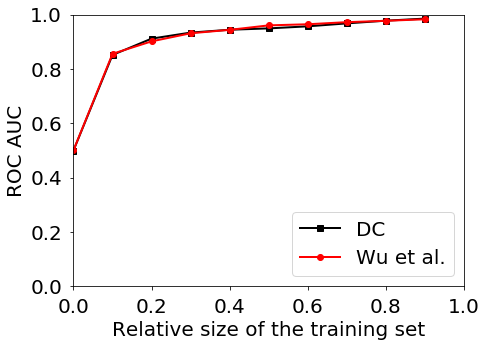

In [10]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results['DC', l1, l2][0], results['DC', l1, l2][2], marker='s', linewidth=2, color = 'black', label='DC')
plt.plot(results['Wu', l1, l2][0], results['Wu', l1, l2][2], marker='o', linewidth=2, color = 'red', label='Wu et al.')


plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

In [11]:
with open('figure4a_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Figure 4b

In [12]:
# 1 Direct interaction
# 2 Suppressive genetic interaction defined by inequality
# 3 Additive genetic interaction defined by inequality
# 4 Physical association
# 5 Colocalization
# 6 Association
# 7 Synthetic genetic interaction defined by inequality



filename = 'Data/multiplex_network-drosophila.edgelist'
G = read_file (filename)

In [13]:
results = {}
step = 0.1

In [14]:
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

66
# Number of nodes  7519
# Number of edges  23911
# Number of nodes  7519
# Number of edges  1798
# Modularity  0.4514262109831653
# Modularity  0.640352307161212
# NMI  0.4899337561154533


In [15]:
l1 = 1
l2 = 3
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

49
# Number of nodes  7486
# Number of edges  23928
# Number of nodes  7486
# Number of edges  1376
# Modularity  0.4569130501109923
# Modularity  0.6714025634633571
# NMI  0.4796788599305848


In [16]:
l1 = 2
l2 = 3
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

469
# Number of nodes  1005
# Number of edges  1395
# Number of nodes  1005
# Number of edges  956
# Modularity  0.6642013848742951
# Modularity  0.7271264071007157
# NMI  0.5887222328779577


(0.0, 1)

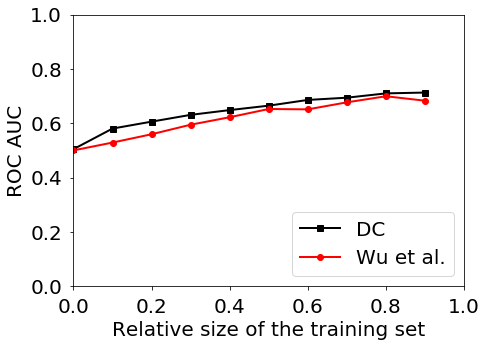

In [17]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results['DC', l1, l2][0], results['DC', l1, l2][2], marker='s', linewidth=2, color = 'black', label='DC')
plt.plot(results['Wu', l1, l2][0], results['Wu', l1, l2][2], marker='o', linewidth=2, color = 'red', label='Wu et al.')


plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

In [18]:
with open('figure4b_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Figure 4c

In [19]:
# 1 Electric ("ElectrJ")
# 2 Chemical Monadic ("MonoSyn")
# 3 Chemical Polyadic ("PolySyn")



filename = 'Data/multiplex_network-celegans.edgelist'
G = read_file (filename)

In [20]:
results = {}
step = 0.1

In [21]:
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

111
# Number of nodes  273
# Number of edges  406
# Number of nodes  273
# Number of edges  777
# Modularity  0.6741609842510131
# Modularity  0.5092864513713935
# NMI  0.36781408568239937


In [22]:
l1 = 1
l2 = 3
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

162
# Number of nodes  277
# Number of edges  355
# Number of nodes  277
# Number of edges  1541
# Modularity  0.6929974211465981
# Modularity  0.44437758166254754
# NMI  0.3759907757937495


In [23]:
l1 = 2
l2 = 3
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

630
# Number of nodes  273
# Number of edges  258
# Number of nodes  273
# Number of edges  1073
# Modularity  0.7032555134907761
# Modularity  0.40535980592862686
# NMI  0.37051456710202446


(0.0, 1)

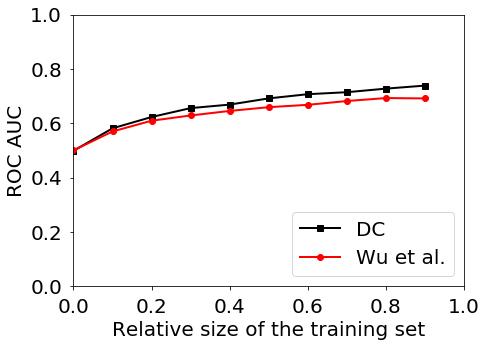

In [24]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results['DC', l1, l2][0], results['DC', l1, l2][2], marker='s', linewidth=2, color = 'black', label='DC')
plt.plot(results['Wu', l1, l2][0], results['Wu', l1, l2][2], marker='o', linewidth=2, color = 'red', label='Wu et al.')


plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

In [25]:
with open('figure4c_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Figure 4d

In [26]:
# 1 The aggregation to a single weighted graph of the networks of stations corresponding to each underground line (e.g., District, Circle, etc)
# 2 The network of stations connected by Overground
# 3 The network of stations connected by DLR


filename = 'Data/multiplex_network-london.edgelist'
G = read_file (filename)

In [27]:
results = {}
step = 0.1

In [28]:
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############


tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

11
# Number of nodes  321
# Number of edges  301
# Number of nodes  321
# Number of edges  72
# Modularity  0.8247922208364147
# Modularity  0.7787422839506173
# NMI  0.6737227260256561


In [30]:
l1 = 1
l2 = 3
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 100
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

0
# Number of nodes  311
# Number of edges  312
# Number of nodes  311
# Number of edges  46
# Modularity  0.8295323800131493
# Modularity  0.696124763705104
# NMI  0.686347745168451


In [35]:
l1 = 2
l2 = 3
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 50
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 50
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

0
# Number of nodes  126
# Number of edges  83
# Number of nodes  126
# Number of edges  46
# Modularity  0.768834373639135
# Modularity  0.69234404536862
# NMI  0.7013192103184374


(0.0, 1)

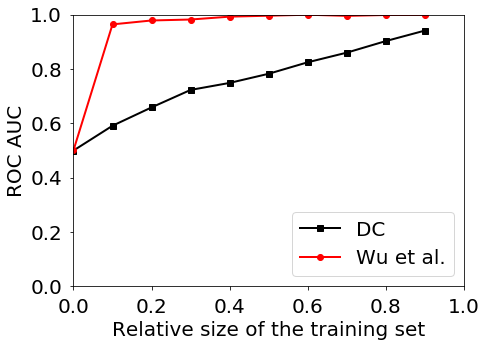

In [36]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results['DC', l1, l2][0], results['DC', l1, l2][2], marker='s', linewidth=2, color = 'black', label='DC')
plt.plot(results['Wu', l1, l2][0], results['Wu', l1, l2][2], marker='o', linewidth=2, color = 'red', label='Wu et al.')


plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

In [37]:
with open('figure4d_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Figure 6a

In [53]:
# 1 Physical association
# 2 Suppressive genetic interaction defined by inequality
# 3 Direct interaction
# 4 Synthetic genetic interaction defined by inequality
# 5 Association
# 6 Colocalization
# 7 Additive genetic interaction defined by inequality


filename = 'Data/sacchpomb_genetic_multiplex.edges'
G = read_file (filename)

In [54]:
results = {}
step = 0.1

In [56]:
l1 = 1
l2 = 3
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

445
# Number of nodes  2577
# Number of edges  1038
# Number of nodes  2577
# Number of edges  6622
# Modularity  0.8732829734074384
# Modularity  0.5068834416200139
# NMI  0.5074561966046608


In [58]:
l1 = 1
l2 = 6
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

52
# Number of nodes  3009
# Number of edges  1431
# Number of nodes  3009
# Number of edges  30752
# Modularity  0.842673290486537
# Modularity  0.2345705343496521
# NMI  0.4404717383862204


In [59]:
l1 = 3
l2 = 6
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

127
# Number of nodes  3782
# Number of edges  6940
# Number of nodes  3782
# Number of edges  30677
# Modularity  0.5211777151209621
# Modularity  0.23133044645851145
# NMI  0.396730203013558


(0.0, 1)

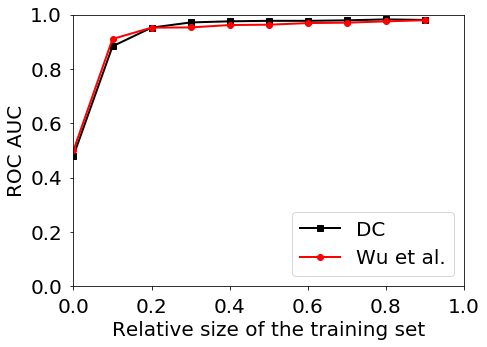

In [60]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results['DC', l1, l2][0], results['DC', l1, l2][2], marker='s', linewidth=2, color = 'black', label='DC')
plt.plot(results['Wu', l1, l2][0], results['Wu', l1, l2][2], marker='o', linewidth=2, color = 'red', label='Wu et al.')


plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

In [61]:
with open('figure6a_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Figure 6b

In [77]:
# 1 Direct interaction
# 2 Physical association
# 3 Suppressive genetic interaction defined by inequality
# 4 Association
# 5 Colocalization
# 6 Additive genetic interaction defined by inequality
# 7 Synthetic genetic interaction defined by inequality



filename = 'Data/homo_genetic_multiplex.edges'
G = read_file (filename)

In [78]:
results = {}
step = 0.1

In [79]:
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############


tmp = {}
T = 1
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 1
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

12284
# Number of nodes  17415
# Number of edges  37361
# Number of nodes  17415
# Number of edges  72004
# Modularity  0.5270395723449751
# Modularity  0.41410441593957314
# NMI  0.3231653035989177


In [80]:
l1 = 1
l2 = 5
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 1
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 1
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

1386
# Number of nodes  13562
# Number of edges  48259
# Number of nodes  13562
# Number of edges  17041
# Modularity  0.49225452927861885
# Modularity  0.6507847924914527
# NMI  0.4014610505109631


In [81]:
l1 = 2
l2 = 5
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 1
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 1
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

2238
# Number of nodes  15254
# Number of edges  82050
# Number of nodes  15254
# Number of edges  16189
# Modularity  0.4170017140749997
# Modularity  0.6424420099713142
# NMI  0.3477566018580057


(0.0, 1)

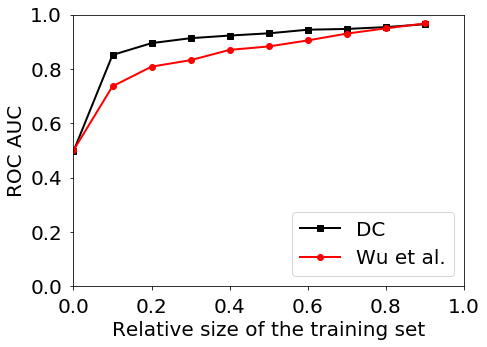

In [82]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results['DC', l1, l2][0], results['DC', l1, l2][2], marker='s', linewidth=2, color = 'black', label='DC')
plt.plot(results['Wu', l1, l2][0], results['Wu', l1, l2][2], marker='o', linewidth=2, color = 'red', label='Wu et al.')


plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

In [83]:
with open('figure6b_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Figure 6c

In [84]:
# 1 Physical association
# 2 Direct interaction
# 3 Colocalization
# 4 Association
# 5 Additive genetic interaction defined by inequality
# 6 Suppressive genetic interaction defined by inequality


filename = 'Data/rattus_genetic_multiplex.edges'
G = read_file (filename)

In [85]:
results = {}
step = 0.1

In [86]:
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

178
# Number of nodes  2520
# Number of edges  2610
# Number of nodes  2520
# Number of edges  832
# Modularity  0.6999341612718539
# Modularity  0.9307341265255178
# NMI  0.6307584850774133


In [87]:
l1 = 1
l2 = 3
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

31
# Number of nodes  2065
# Number of edges  2757
# Number of nodes  2065
# Number of edges  88
# Modularity  0.7063108657765527
# Modularity  0.9052169421487598
# NMI  0.5930702483511365


In [88]:
l1 = 2
l2 = 3
G1, G2 = duplex_network (G, l1, l2)

#############

print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))

C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)

###############



tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, TT=0)
results['DC', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['DC', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['DC', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['DC', l1, l2][2,q] += tmp[t][2][q]/float(T)
# print (results['DC', l1, l2])


tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis_wu_et_al (G1, G2, step)
results['Wu', l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results['Wu', l1, l2][0,q] += tmp[t][0][q]/float(T)
        results['Wu', l1, l2][1,q] += tmp[t][1][q]/float(T)
        results['Wu', l1, l2][2,q] += tmp[t][2][q]/float(T)

# results['DC', l1, l2] = perform_analysis (G1, G2, step, TT=0)
# results['Wu', l1, l2] = perform_analysis_wu_et_al (G1, G2, step)

19
# Number of nodes  1074
# Number of edges  991
# Number of nodes  1074
# Number of edges  100
# Modularity  0.9208451237728847
# Modularity  0.91005
# NMI  0.7779186415427924


(0.0, 1)

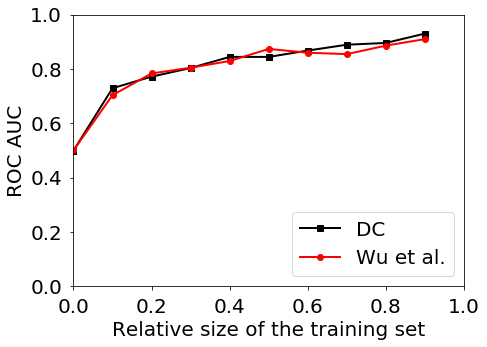

In [89]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results['DC', l1, l2][0], results['DC', l1, l2][2], marker='s', linewidth=2, color = 'black', label='DC')
plt.plot(results['Wu', l1, l2][0], results['Wu', l1, l2][2], marker='o', linewidth=2, color = 'red', label='Wu et al.')


plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

In [90]:
with open('figure6c_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)